# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 3 sections:
- Vehicle Behaviour
- Reward Properties
- Track Analysis

## Import modules

In [20]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


## Load log

In [5]:
stream_name = 'sim-qkhmtwkbgt96' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [6]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [7]:
EPISODES_PER_ITERATION = 50 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [8]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.1831,-2.1737,-179.6744,10.0,2.0,4.0,22.4454,0,True,0.2745,1,60.0,1590440242.2859545
1,1,0,4,0.1456,-2.1758,-178.9912,-10.0,2.0,2.0,17.8456,0,True,0.3369,1,60.0,1590440242.3580942
2,1,0,5,0.0894,-2.1789,-178.2760,-10.0,2.0,2.0,15.9503,0,True,0.4306,1,60.0,1590440242.425499
3,1,0,6,0.0402,-2.1814,-177.9294,-10.0,2.0,2.0,14.0765,0,True,0.5126,1,60.0,1590440242.4949355
4,1,0,7,-0.0502,-2.1855,-177.6975,-30.0,1.4,0.0,13.9557,0,True,0.6633,1,60.0,1590440242.552942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66421,11,537,131,-6.1416,-0.9622,88.4670,10.0,2.0,4.0,2.9332,0,True,26.9468,29,60.0,1590447463.4506366
66422,11,537,132,-6.1125,-0.6156,85.8100,30.0,1.4,6.0,2.9452,0,True,27.5269,30,60.0,1590447463.4781954
66423,11,537,133,-6.1100,-0.5548,86.3638,20.0,1.7,5.0,2.9230,0,True,27.6231,30,60.0,1590447463.5381877
66424,11,537,134,-6.1076,-0.4598,87.4738,20.0,1.7,5.0,2.9054,0,True,27.7806,31,60.0,1590447463.607689


# Vehicle Behaviour
## Action distribution

In [9]:
df['action'].value_counts().sort_index()

0.0    16391
1.0     7493
2.0     8666
3.0     6174
4.0     6953
5.0    10872
6.0     9877
Name: action, dtype: int64

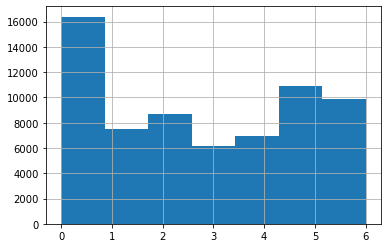

In [10]:
df['action'].hist(bins=7)

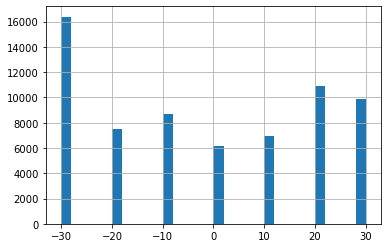

In [11]:
df['steer'].hist(bins=30)

In [12]:
# once cmap support for pu.plot_track is added, plot steering around the track
#pu.plot_track(df, track, value_field='steer', margin=1, cmap='bwr')

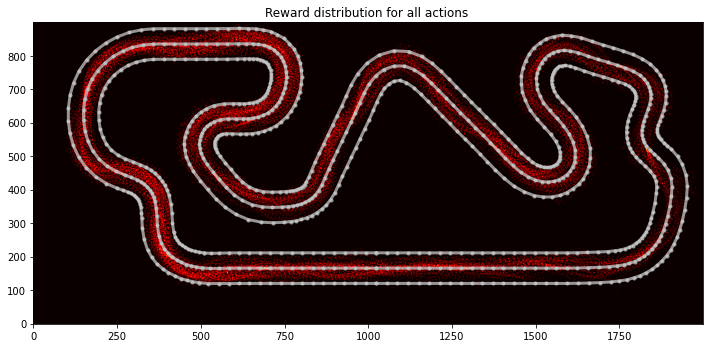

<Figure size 432x288 with 0 Axes>

In [13]:
pu.plot_track(df, track, value_field='throttle', margin=1)

## Progress per steps

In [14]:
df['pps'] = df['progress'].values / (1 + df['steps'].values)

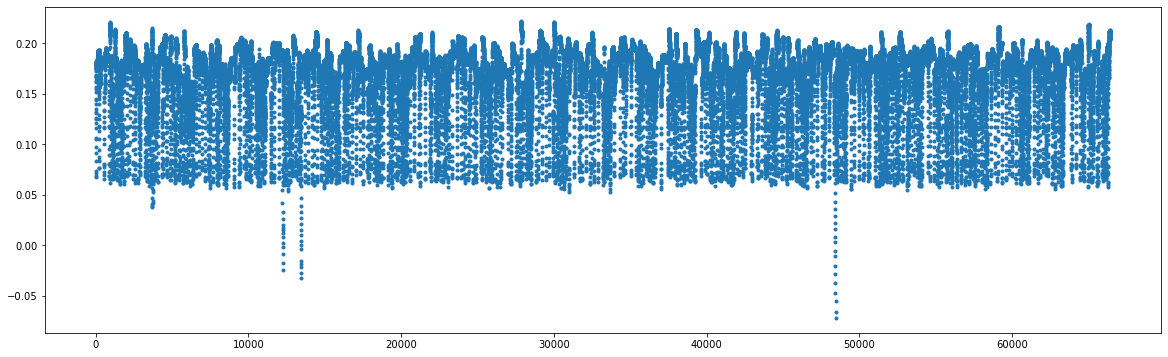

In [52]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,len(df)), df['pps'], '.')

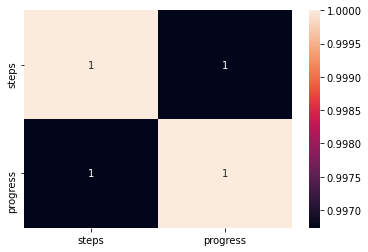

In [15]:
sns.heatmap(df[['steps', 'progress']].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa132fdd90>,
      dtype=object)

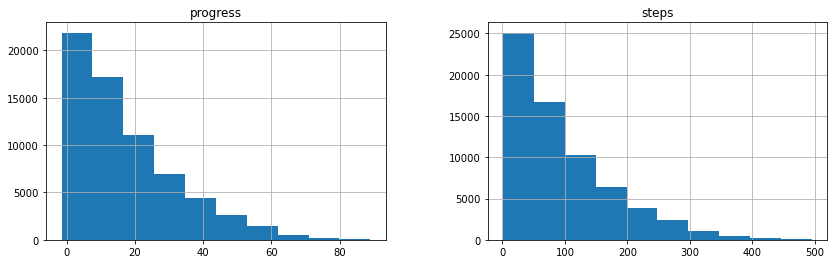

In [16]:
df[['steps', 'progress']].hist(figsize=(14,4))

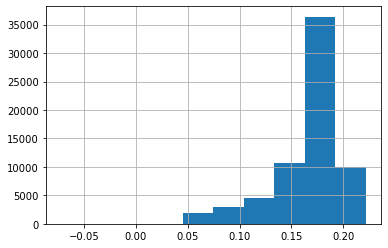

In [17]:
df['pps'].hist()

## Progress and progression tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care about distance covered towards the finish line.

In [32]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        if last < progress[x]:
            d = progress[x] - last
        result[x] = d
        last = max(float(progress[x]), 0.0)
    return result

In [21]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + r['progress'] / 10.0) for _,r in df.iterrows()]

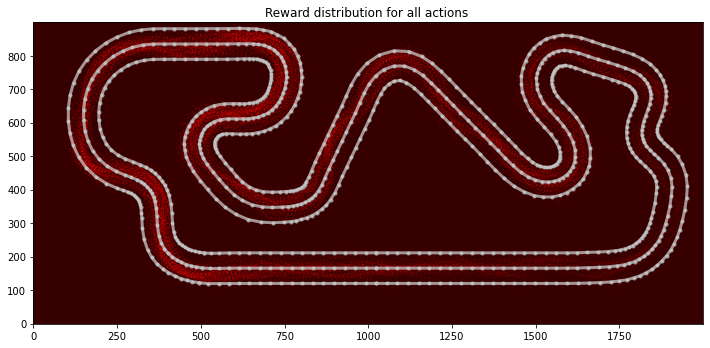

<Figure size 432x288 with 0 Axes>

In [22]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [33]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

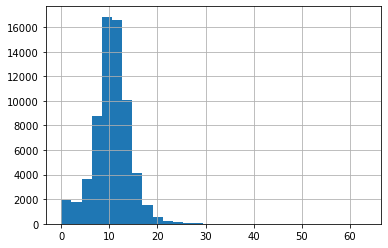

In [34]:
df['tempo'].hist(bins=30)

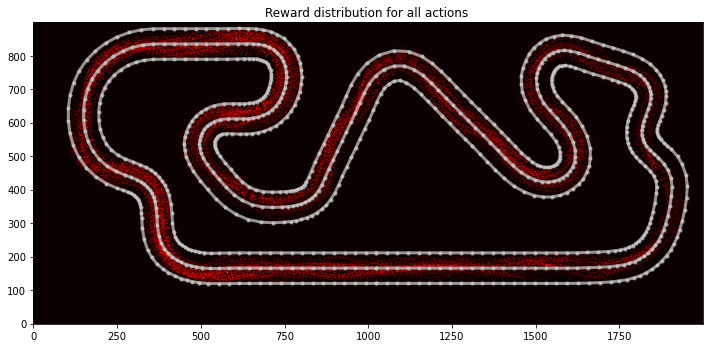

<Figure size 432x288 with 0 Axes>

In [35]:
pu.plot_track(df[df['tempo'] < 16], track, value_field='tempo')

# Reward Properties
## Helper definitions

In [36]:
def plot_track(t):
    ratio = (lambda x,y: x / y)(*t.size())
    fig = plt.figure(figsize=(16,16/ratio))
    ax = fig.add_subplot()
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [37]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering', 'track_len':'track_length', 'progress':'progress', 'steps':'steps'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    d.update({'is_reversed':False, 'waypoints':track.center_line})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [38]:
import importlib

## Apply different reward

In [78]:
name = 'adversarial'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [79]:
original = 'prototype'
df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [80]:
df[name] = [1 + reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa10f6b640>,
      dtype=object)

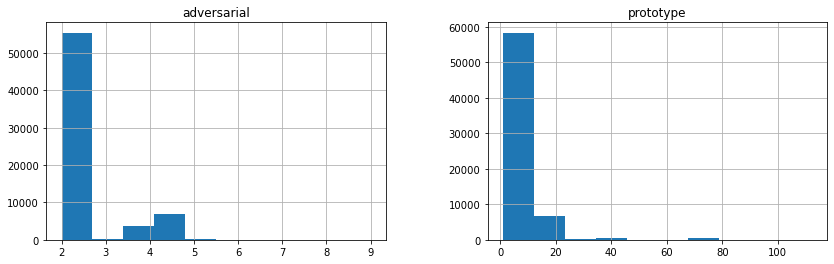

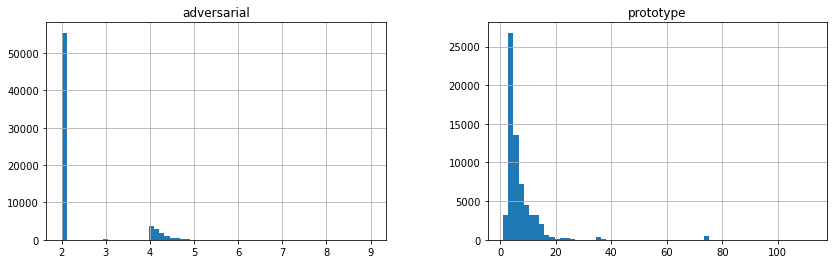

In [81]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [82]:
sample = df.sample(frac=0.75)

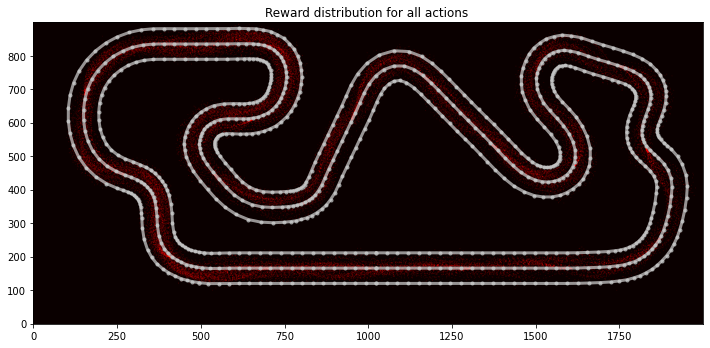

<Figure size 432x288 with 0 Axes>

In [83]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

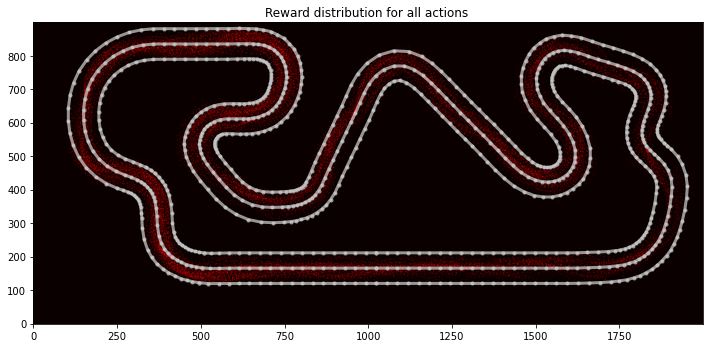

<Figure size 432x288 with 0 Axes>

In [84]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

Text(0.5, 1.0, 'adversarial')

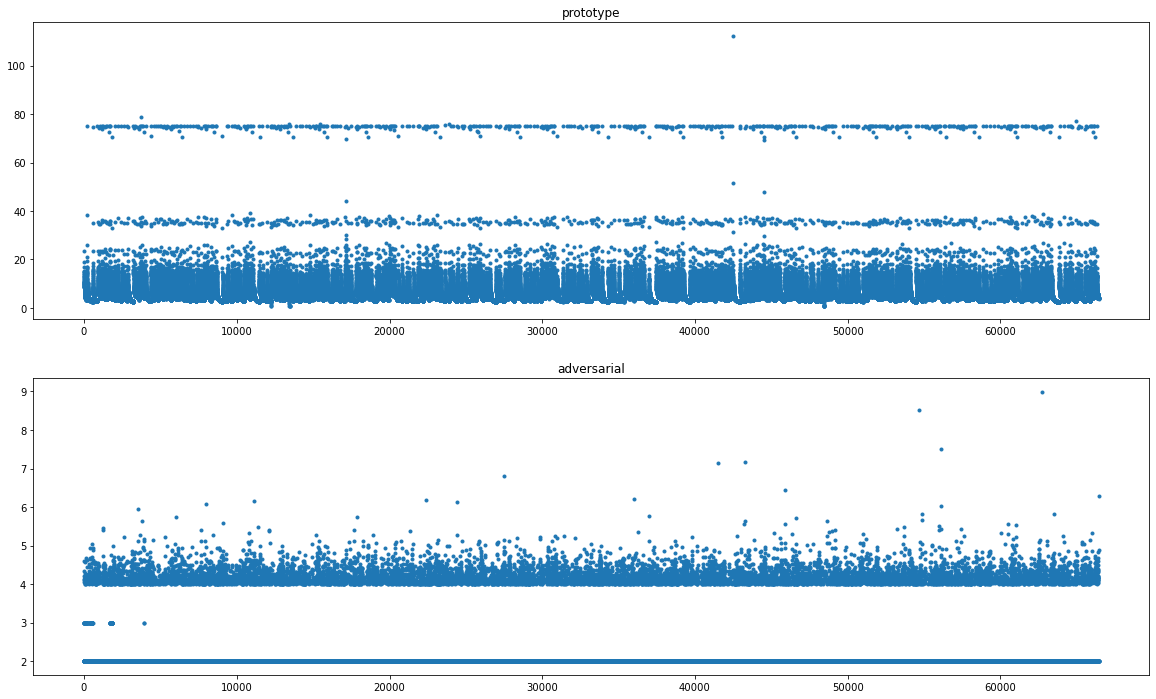

In [85]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(np.arange(0,len(df)), df[original], '.')
plt.title(original)

plt.subplot(2,1,2)
plt.plot(np.arange(0,len(df)), df[name], '.')
plt.title(name)

# Track Analysis
## Sector builder
Let's define sectors around the track. Mapping closest waypoint coordinates as a sector mark works well and can be used to construct interesting reward that stimulates improving every part of the track evenly.

In [74]:
DENSITY = 2.0
key = lambda wpt: [int(round(c * DENSITY)) / DENSITY for c in wpt]
keys = np.array([key(w) for w in track.center_line])

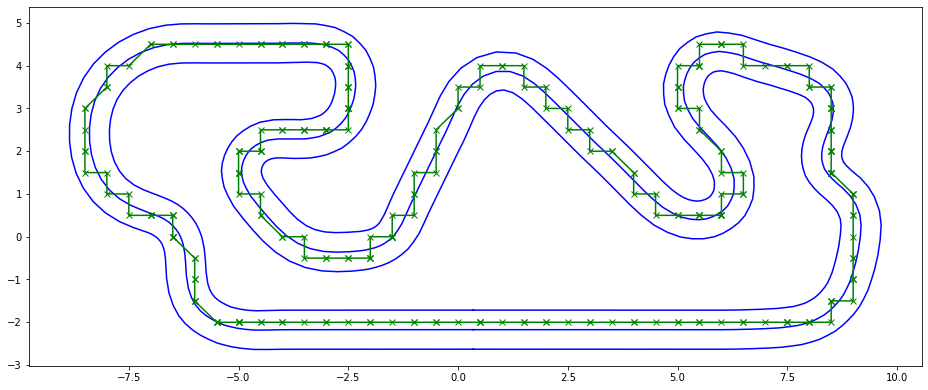

In [75]:
ax = plot_track(track)
ax.plot(*keys.T, 'gx-')

## Plot saved sectors
If your reward function implements sectors global variable storing model records, you can plot it here.

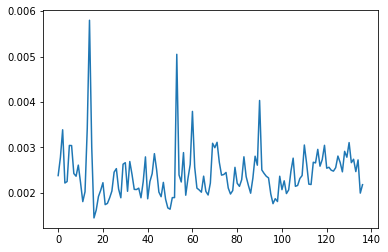

In [86]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

In [2]:
def plot3d_reward(x, y, r):
    X, Y = np.meshgrid(x, y)
    Z = r(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    return ax

In [ ]:
    def plot_track(df, track: Track, value_field="reward", margin=1, cmap="hot"):
        """Plot track with dots presenting the rewards for steps
        """
        track_size = (np.asarray(track.size()) + 2*margin).astype(int) * 100
        track_img = np.zeros(track_size).transpose()

        x_coord = 0
        y_coord = 1

        # compensation moves car's coordinates in logs to start at 0 in each dimention
        x_compensation = df['x'].min()
        y_compensation = df['y'].min()

        for _, row in df.iterrows():
            x = int((row["x"] - x_compensation + margin) * 100)
            y = int((row["y"] - y_compensation + margin) * 100)

            # clip values that are off track
            if y >= track_size[y_coord]:
                y = track_size[y_coord] - 1

            if x >= track_size[x_coord]:
                x = track_size[x_coord] - 1

            track_img[y, x] = row[value_field]

        fig = plt.figure(1, figsize=(12, 16))
        ax = fig.add_subplot(111)

        shifted_track = Track("shifted_track", (track.waypoints -
                                                [x_compensation, y_compensation]*3 + margin) * 100)

        PlottingUtils.print_border(ax, shifted_track)

        plt.title("Reward distribution for all actions ")
        plt.imshow(track_img, cmap=cmap, interpolation='bilinear', origin="lower")

        plt.show()
        plt.clf()
